# 6.5 Edmonton AC Loads: Gridded Example

This worked example will show you how to implement a true "downscaling" method to produce calibrated high-resolution climate projections. Using gridded data for climate impact analysis, instead of one or more point locations, allows you to study the spatial variaiblity in your indicator and its future projections. Some variables may be fairly spatially uniform over the scale of a particular urban region, but others may show significant spatial structure in both the historical climate and the projected changes, due to a number of factors. These small-scale spatial variations can lead to different impacts on different communities. Accounting for spatial variability is important for being able to quantify the unequal effects of climate change on historically marginalized groups of people, since populations of ethnic minorities, the elderly, and the disabled are also typically spatially heterogeneous. These groups of people already suffer greater exposure to climate risks, and this inequality could be amplified by unfavourable spatial patterns of climatic changes. Social justice is only one reason why gridded climate projections are useful, but we choose to highlight it here since it is often overlooked in favour of other less human-centred scientific focuses.

## 6.5.1 Study Design

This notebook will expand on the examples of Sections 6.1-6.4 and make projections of Cooling Degree Days in a region around the city of Edmonton. To clearly illustrate the value of higher spatial resolution, we'll use a $5^{\circ} \times 10^{\circ}$ latitude $\times$ longitude region centred on the city. This encompasses most of Northern Alberta, but since it extends westward into a region of high elevation and complex topography, it really shows the improvements that can be offered by high spatial resolution. 

Like 6.1-6.3, we will use 1980-2010 as the historical baseline period and 2070-2100 as the future projection period. Because of the much larger volume of data that comes with using high-resolution gridded climate data, we'll return to the scope of Section 6.1 and use only a single model (CESM2) and future scenario (SSP3-7.0). 

The gridded observational product we will use in this notebook is the ERA5-Land reanalysis. This is not really observations, but is instead output from the ECMWF weather forecast model, which assimilates observations. We use this data since the true gridded observational product we used previously in Sections 3.2 and 4.4, the NRCanMet product, does not offer daily mean temperature, which we need to calculate CDDs. ERA5-Land has a spatial resolution of about 9 km $\times$ 9 km, slightly higher than NRCanMet. More information about ERA5-Land can be found [here](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation).

The downscaling method we will employ in this example is "Double Bias Corrected Constructed Analogues", or DBCCA. This method is explained in detail in [Section 4.3.3.2](https://utcdw.physics.utoronto.ca/UTCDW_Guidebook/Chapter4/section4.3_downscaling_methods.html#bias-corrected-constructed-analogues) and [Werner and Cannon (2016)](https://doi.org/10.5194/hess-20-1483-2016). In short, it produces downscaled model output using an optimal linear combination of high-resolution observations (BCCA) with a quantile mapping bias correction step after the fact (DBCCA). Code for both the BCCA and DBCCA methods can be found in the [UTCDW GitHub repository](https://github.com/mikemorris12/UTCDW_Guidebook) in downscaling_code/BCCA.py and downscaling_code/DBCCA.py respectively. Before continuing, please review the aforementioned links and the docstrings for each function in the aforementioned Python scripts, so you can get an idea of how the methods work and how they are implemented.


In [1]:
# add the downscaling_code directory to the PATH so the functions can be imported. 
# you will need to change the argument passed to sys.path.append() to be wherever you
# saved the scripts when you cloned the repository or downloaded the scripts individually.
import sys
sys.path.append("/home/mmorris/UTCDW/downscaling_code")

# now import the DBCCA function
from DBCCA import DBCCA

# import other the necessary packages
import numpy as np
import xarray as xr
import dask
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import pandas as pd
import ec3
import xclim.indices as xci
import gcsfs
import zarr
import os

spkws = dict(projection = ccrs.PlateCarree(), transform = ccrs.PlateCarree())

# spatial boundaries of our study region - a 5x5 degree region around Edmonton
lat_bnds = [50.75, 55.75]
lon_bnds = [-116-2.5, -111+2.5]
lon_bnds360 = [l + 360 for l in lon_bnds]

# time periods for historical and future periods
years_hist = range(1980, 2011)
years_future = range(2070, 2101)

# url for the CSV file that contains the CMIP model data catalog
url_gcsfs_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'

# PAVICS URL for ERA5 data
url_pavics_era5 = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/reanalyses/catalog.xml"

## 6.5.2 Downloading the Data

Conveniently, the ERA5-Land data for North America is available from the PAVICS OPeNDAP server, and it can be accessed just the same as the ERA5 data in [Section 3.3](https://utcdw.physics.utoronto.ca/UTCDW_Guidebook/Chapter3/section3.3_reanalysis.html). The hidden code cells below will download the ERA5-Land data, plus the CESM2 historical and SSP3-7.0 data for ensemble member `r10i1p1f1`, and subset to select the desired spatial domain and time periods. 

In [2]:
# access the ERA5-LAND data through the OPenDAP server
cat = TDSCatalog(url_pavics_era5)
ix = list(cat.datasets).index("day_ERA5-Land_NAM.ncml")
era5_ds = xr.open_dataset(cat.datasets[ix].access_urls["OPENDAP"])

# subset spatially and temporally
tas_obs = era5_ds.tas.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds), 
                          time = era5_ds.time.dt.year.isin(years_hist))
# convert units
tas_obs = tas_obs - 273.15

# print a summary of the dataset
tas_obs

<xarray.DataArray 'tas' (time: 11323, lat: 50, lon: 101)>
array([[[ -3.511078 ,  -4.6818237,  -5.0390625, ...,  -7.0808716,
          -7.0299683,  -7.010742 ],
        [ -3.5059814,  -4.129883 ,  -3.9648743, ...,  -7.801941 ,
          -7.781708 ,  -7.7473145],
        [ -3.557129 ,  -3.340088 ,  -3.0634155, ...,  -8.422668 ,
          -8.387024 ,  -8.481689 ],
        ...,
        [-11.6189575, -11.551941 , -11.608215 , ..., -11.563629 ,
         -11.5095215, -11.457123 ],
        [-11.442688 , -11.456848 , -11.544525 , ..., -11.596558 ,
         -11.554047 , -11.659119 ],
        [-11.397095 , -11.42215  , -11.487366 , ..., -11.845367 ,
         -11.789856 , -11.734436 ]],

       [[ -3.822876 ,  -4.788269 ,  -5.0567017, ...,  -7.7540283,
          -7.7863464,  -7.8150635],
        [ -3.831726 ,  -4.345642 ,  -4.234497 , ...,  -8.073914 ,
          -8.111206 ,  -8.138245 ],
        [ -3.9239502,  -3.777008 ,  -3.586029 , ...,  -8.401611 ,
          -8.434082 ,  -8.515869 ],
...
        [-25.356369 , -26.510025 , -26.94188  , ..., -22.074005 ,
         -21.99501  , -21.88292  ],
        [-26.577469 , -27.182388 , -27.279068 , ..., -21.797318 ,
         -21.757797 , -21.88057  ],
        [-27.480179 , -27.394516 , -27.173447 , ..., -22.309738 ,
         -22.124542 , -21.847748 ]],

       [[-16.320526 , -16.967407 , -17.010742 , ..., -20.066483 ,
         -19.921036 , -19.8517   ],
        [-16.78778  , -17.203384 , -17.155487 , ..., -20.448761 ,
         -20.281204 , -20.21907  ],
        [-17.401505 , -17.528778 , -17.524033 , ..., -20.862274 ,
         -20.71457  , -20.560837 ],
        ...,
        [-18.356293 , -20.500748 , -21.051132 , ..., -19.369537 ,
         -19.656845 , -19.869293 ],
        [-20.29924  , -21.571213 , -21.803207 , ..., -19.817963 ,
         -20.001358 , -20.234268 ],
        [-21.57277  , -21.67418  , -21.665497 , ..., -22.246964 ,
         -21.899323 , -20.370209 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 50.8 50.9 51.0 51.1 51.2 ... 55.3 55.4 55.5 55.6 55.7
  * lon      (lon) float32 -118.5 -118.4 -118.3 -118.2 ... -108.7 -108.6 -108.5
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2010-12-31

In [4]:
# download the CESM2 model data from Google Cloud - this code is mostly the same as 6.1

# open the Google Cloud model data catalog with pandas
df_catalog = pd.read_csv(url_gcsfs_catalog)

# search for our selected model, both historical and SSP3-7.0 scenarios
search_string = "table_id == 'day' & source_id == 'CESM2' & variable_id == 'tas'" # continue on the next line
search_string += " & experiment_id == ['historical', 'ssp370']"
df_search = df_catalog.query(search_string)

# filter the search results further for the ensemble member we want to use
df_search_r10i1p1f1 = df_search.query("member_id == 'r10i1p1f1'")

# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# get the URLs for each dataset and turn into zarr store mappers
url_hist = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'historical'].zstore.values[0]
mapper_hist = gcs.get_mapper(url_hist)
url_ssp3 = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'ssp370'].zstore.values[0]
mapper_ssp3 = gcs.get_mapper(url_ssp3)

# download the datasets, subset, and convert units
# historical
ds_hist_raw = xr.open_zarr(mapper_hist, consolidated = True)
tas_hist_raw = ds_hist_raw.tas.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds360)) - 273.15 # also convert to C

# future
ds_ssp3_raw = xr.open_zarr(mapper_ssp3, consolidated = True)
tas_ssp3_raw = ds_ssp3_raw.tas.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds360)) - 273.15 

# select time periods
tas_hist_raw = tas_hist_raw.sel(time = tas_hist_raw.time.dt.year.isin(years_hist))
tas_ssp3_raw = tas_ssp3_raw.sel(time = tas_ssp3_raw.time.dt.year.isin(years_future))

## 6.5.3 Exploratory Analysis

### 6.5.3.1 Model/Obs Consistency

To get a sense of the difference in spatial scale between the raw model data and the high-res ERA5-Land data, we can plot maps using the matplotlib `pcolormesh` routine. Like before, let's compare the raw model historical climatology of daily mean temperature to the "observations". To limit the number of maps, we'll plot the monthly climatologies instead of the daily climatologies, which we did in the 1D examples. Each panel represents the long-term mean for a different month of the year. The subplot titles indicate the order of the months (i.e. 1 is January, 2 is February, etc.). 

In [5]:
# calculate the raw model historical monthly climatology
tas_hist_raw_monthlyclim = tas_hist_raw.groupby('time.month').mean('time').compute()

# same for observations
tas_obs_monthlyclim = tas_obs.groupby('time.month').mean('time').compute()

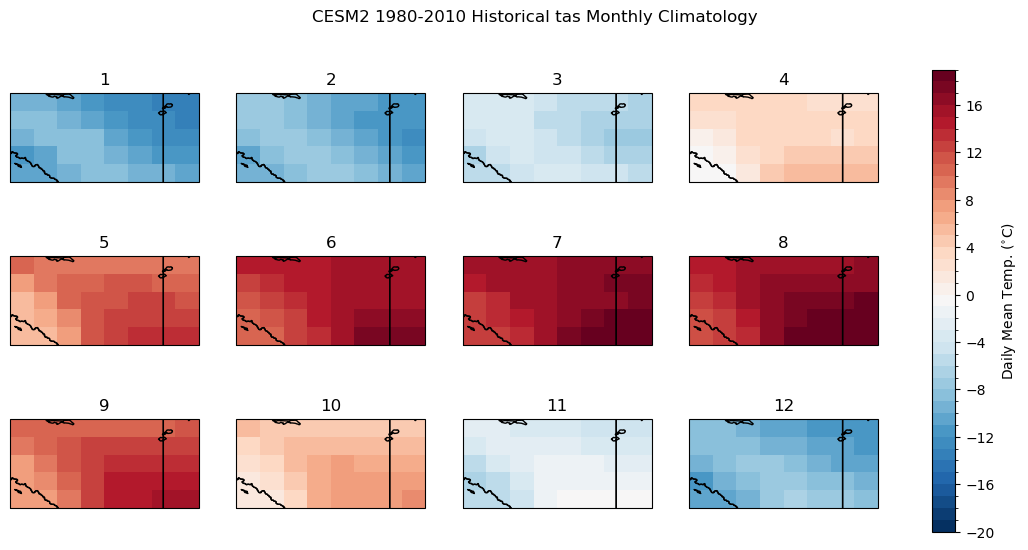

In [6]:
# plot model monthly clim
fig, axes_array = plt.subplots(nrows = 3, ncols = 4, subplot_kw = spkws, figsize = (14, 6))
axes = axes_array.ravel()
fig.suptitle("CESM2 1980-2010 Historical tas Monthly Climatology")
for i in range(len(axes)):
    p = tas_hist_raw_monthlyclim.sel(month = i+1).plot.pcolormesh(ax = axes[i],
                                                                  levels = np.arange(-20, 20, 1),
                                                                  cmap = 'RdBu_r',
                                                                  add_colorbar = False)
    axes[i].set_title(i + 1)
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    axes[i].add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    axes[i].add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    
fig.colorbar(p, ax = axes.tolist(), label = r"Daily Mean Temp. ($^{\circ}$C)")

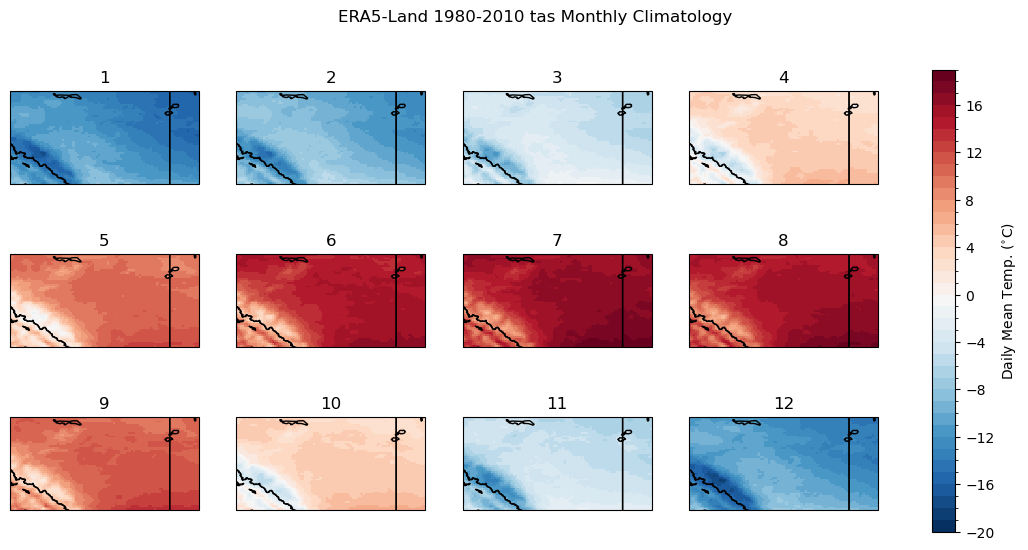

In [7]:
# plot model monthly clim
fig, axes_array = plt.subplots(nrows = 3, ncols = 4, subplot_kw = spkws, figsize = (14, 6))
axes = axes_array.ravel()
fig.suptitle("ERA5-Land 1980-2010 tas Monthly Climatology")
for i in range(len(axes)):
    p = tas_obs_monthlyclim.sel(month = i+1).plot.pcolormesh(ax = axes[i],
                                                                  levels = np.arange(-20, 20, 1),
                                                                  cmap = 'RdBu_r',
                                                                  add_colorbar = False)
    axes[i].set_title(i + 1)
    axes[i].coastlines()
    axes[i].add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    axes[i].add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    axes[i].add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)
    
fig.colorbar(p, ax = axes.tolist(), label = r"Daily Mean Temp. ($^{\circ}$C)")
plt.show()

Immediately we can see that the higher spatial resolution of ERA5-Land resolves the effects of the complex terrain and higher elevation along the mountains. Take the months of April (4) and October (10) for example: CESM2 shows slightly colder mean temperatures in the southwest corner of the domain, near zero degrees for a few grid cells. ERA5-Land's 9 km resolution allows it to resolve the regions of colder and warmer mean temperature in this region, with the higher elevations having negative long-term mean temperatures, and a small valley again showing a positive climatological mean. These features are amongst those we'd like to resolve in the downscaled climate projections.

Next let's calculate the historical long-term mean CDDs for each grid cell, for the raw model and observations. We can do this using the same function calls as for the 1D station data in the previous examples - the code automatically applies the function separately over each grid cell.


In [8]:
# add unit attribute required by xclim
tas_obs.attrs['units'] = 'degC'
tas_hist_raw.attrs['units'] = 'degC'
tas_ssp3_raw.attrs['units'] = 'degC'

# calculate CDDs for each dataset
cdds_obs = xci.cooling_degree_days(tas_obs).compute()
cdds_hist_raw = xci.cooling_degree_days(tas_hist_raw).compute()
cdds_ssp3_raw = xci.cooling_degree_days(tas_ssp3_raw).compute()

# long-term annual means
cdds_obs_ltm = cdds_obs.mean('time').compute()
cdd_hist_raw_ltm = cdds_hist_raw.mean('time').compute()
cdd_ssp3_raw_ltm = cdds_ssp3_raw.mean('time').compute()

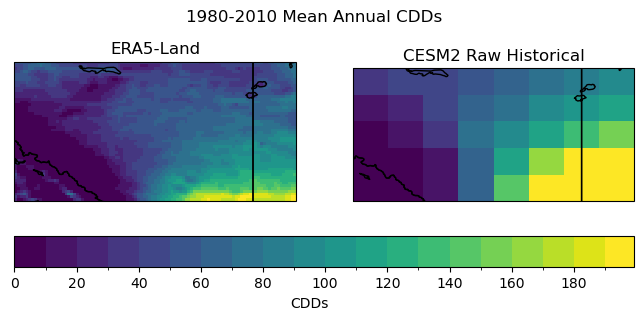

In [9]:
# plot maps of long-term mean CDDs for raw historical and obs
levels_cdd = np.arange(0, 200, 10)
fig, axes = plt.subplots(ncols = 2, subplot_kw = spkws, figsize = (8, 3))
fig.suptitle("1980-2010 Mean Annual CDDs")
p0 = cdds_obs_ltm.plot.pcolormesh(ax = axes[0], add_colorbar = False, levels = levels_cdd)
axes[0].set_title("ERA5-Land")
p1 = cdd_hist_raw_ltm.plot.pcolormesh(ax = axes[1], add_colorbar = False, levels = levels_cdd)
axes[1].set_title("CESM2 Raw Historical")

fig.colorbar(p0, ax = axes.ravel().tolist(), label = "CDDs", orientation = 'horizontal', extendrect = True)

for ax in axes:
    ax.coastlines()
    ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
    ax.add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
    ax.add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)

plt.show()

Just like the temperature climatology, the pseudo-observations show much more spatial detail, including topographic effects in the southwest corner of the domain. The coarse resolution of the climate model output does not allow for representation of fine-scale features, only capturing large-scale gradients on the order of hundreds of kilometers. 

### 6.5.3.2 Raw Model Climate Change Signal

Next we will plot the raw model climate change projections of annual mean CDDs. Later, we can compare this plot to the downscaled projections, to examine the effect of downscaling on the results.

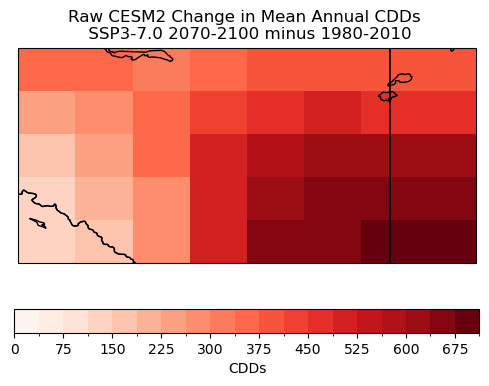

In [10]:
# plot maps of changes long-term mean CDDs for raw CESM2
levels_cdd_delta = np.arange(0, 750, 37.5)
fig, ax = plt.subplots( subplot_kw = spkws, figsize = (6, 4))

cdd_delta_raw = cdd_ssp3_raw_ltm - cdd_hist_raw_ltm

cdd_delta_raw.plot.pcolormesh(ax = ax, levels = levels_cdd_delta, 
                              cbar_kwargs = dict(orientation = 'horizontal', label = 'CDDs'),
                              cmap = 'Reds')

ax.coastlines()
ax.add_feature(cfeature.LAKES, edgecolor = 'k', facecolor = 'none', zorder = 2)
ax.add_feature(cfeature.STATES, edgecolor = 'k', zorder = 2)
ax.add_feature(cfeature.BORDERS, edgecolor = 'k', zorder = 2)

ax.set_title("Raw CESM2 Change in Mean Annual CDDs \n SSP3-7.0 2070-2100 minus 1980-2010")

plt.show()

The magnitude of the changes varies quite significantly within the region. Near the centre, where the city of Edmonton is located, the magnitude is of course essentially the same as in Section 6.1 which used the same model and future scenario. However, the southeast region with its higher elevation and overall colder climate shows smaller increases to CDDs, while the southeastern region has an even stronger projected increase than the centre. These large-scale structures will remain in the downscaled projections, but the hope is that the downscaling adds some fine-scale details.

## 6.5.4 Applying DBCCA Downscaling

Now it is time to produce our downscaled daily mean temperature data using the DBCCA method. As mentioned, code that implements this method is provided in the [UTCDW GitHub repository](https://github.com/mikemorris12/UTCDW_Guidebook). 

```{note}
Because of the greater volumes of data involved in gridded downscaling, and the greater complexity of constructed analogue downscaling methods compared to 1D bias correction methods, expect the following code cells to take much longer to run compared to those applying bias correction in sections 6.1-6.4. The provided CA code is not well optimized, it processes each time step individually using a for-loop. Eventually this code may be improved, or you may wish to take it upon yourself to optimize the code to process different time steps in parallel.
```



In [ ]:
# de-chunk along the time dimension, required by xclim bias correction routines
tas_hist_raw = tas_hist_raw.chunk({'time': -1})
tas_ssp3_raw = tas_ssp3_raw.chunk({'time': -1})
tas_obs = tas_obs.chunk({'time': -1})

In [ ]:
# file names for intermediate BCCA files - saving these will help the code run faster if all
# you want to do is the last QDM step
file_hist_bcca = ""
file_ssp3_bcca = ""

# file paths for DBCCA output - it's good to save this because the code can take a long time to run
file_hist_dbcca = "dbcca_data/tas.daily.CESM2.edmonton.historical.r10i1p1f1.1980-2010.DBCCA.nc"
file_ssp3_dbcca = "dbcca_data/tas.daily.CESM2.edmonton.ssp370.r10i1p1f1.2070-2100.DBCCA.nc"

# do the downscaling - this will only run if the input files don't already exist
if (not os.path.exists(file_hist_dbcca)) or (not os.path.exists(file_ssp3_dbcca))
    tas_hist_dbcca, tas_ssp3_dbcca = DBCCA(tas_hist_raw,
                                           tas_ssp3_raw,
                                           tas_obs,
                                           "tas", 
                                           units = "degC",
                                           fout_hist_bcca = fout_hist_bcca,
                                           fout_future_bcca = fout_future_bcca,
                                           fout_hist_dbcca = fout_hist_dbcca,
                                           fout_future_dbcca = fout_future_dbcca
                                           write_output = True)
else: # open pre-computed DBCCA data
    ds_hist_dbcca = xr.open_dataset(file_hist_dbcca)
    tas_hist_dbcca = ds_hist_dbcca.tas
    ds_ssp3_dbcca = xr.open_dataset(file_ssp3_dbcca)
    tas_ssp3_dbcca = ds_ssp3_dbcca.tas